This notebook takes a trained model and evaluates it on the following metrics:
1. ECE pre and post temperature scaling
2. MCE pre and post temperature scaling
3. Test error

In [1]:
import os
import sys
cwd = os.getcwd()
module_path = "/".join(cwd.split('/')[0:-1])
if module_path not in sys.path:
    sys.path.append(module_path)
import torch
import random
import matplotlib.pyplot as plt
import torch.backends.cudnn as cudnn

In [2]:
%cd /mnt/LFS

/mnt/LFS


In [3]:
# Import dataloaders
import dataset.cifar10 as cifar10
import dataset.cifar100 as cifar100
import dataset.tiny_imagenet as tiny_imagenet

In [4]:
# Import network architectures
from module.resnet import resnet50, resnet110
from module.wide_resnet import wide_resnet_cifar
from module.densenet import densenet121
from module.resnet_tiny_imagenet import resnet50 as resnet50_ti

In [5]:
# Import metrics to compute
from Metrics.metrics import expected_calibration_error
from Metrics.metrics import maximum_calibration_error
from Metrics.metrics import l2_error
from Metrics.plots import reliability_plot, bin_strength_plot
from Metrics.metrics import test_classification_net_focal

In [6]:
# Dataset params

dataset_num_classes = {
    'cifar10': 10,
    'cifar100': 100,
    'tiny_imagenet': 200
}

dataset_loader = {
    'cifar10': cifar10,
    'cifar100': cifar100,
    'tiny_imagenet': tiny_imagenet
}

In [7]:
# Mapping model name to model function
models = {
    'resnet50': resnet50,
    'resnet50_ti': resnet50_ti,
    'resnet110': resnet110,
    'wide_resnet': wide_resnet_cifar,
    'densenet121': densenet121,
}

In [8]:
# Checking if GPU is available
cuda = False
if (torch.cuda.is_available()):
    cuda = True

# Setting additional parameters
torch.manual_seed(1)
device = torch.device("cuda" if cuda else "cpu")

In [9]:
class args:
    data_aug = True
    gpu = device == "cuda"
    train_batch_size = 128
    test_batch_size = 128

In [10]:

dataset = "cifar10"
num_classes = dataset_num_classes[dataset]

if (dataset == 'tiny_imagenet'):
    print ('Enter dataset root path: ')
    dataset_root = input()
    train_loader = dataset_loader[dataset].get_data_loader(
        root=dataset_root,
        split='train',
        batch_size=args.train_batch_size,
        pin_memory=args.gpu)

    val_loader = dataset_loader[dataset].get_data_loader(
        root=dataset_root,
        split='val',
        batch_size=args.test_batch_size,
        pin_memory=args.gpu)

    test_loader = dataset_loader[dataset].get_data_loader(
        root=dataset_root,
        split='val',
        batch_size=args.test_batch_size,
        pin_memory=args.gpu)
else:
    train_loader, val_loader = dataset_loader[dataset].get_train_valid_loader(
        batch_size=args.train_batch_size,
        augment=args.data_aug,
        random_seed=1,
        pin_memory=args.gpu
    )

    test_loader = dataset_loader[dataset].get_test_loader(
        batch_size=args.test_batch_size,
        pin_memory=args.gpu
    )

Files already downloaded and verified
Files already downloaded and verified


In [11]:
model_name = "resnet50"
print ('Enter saved model name: ')

model = models[model_name]

Enter saved model name: 


# LFS-MC

[[958   3  10   4   1   1   3   1  13   6]
 [  2 972   0   0   1   0   0   0   1  24]
 [  9   0 926  16  18   9  15   4   2   1]
 [  5   1  12 901   9  43  13   7   5   4]
 [  1   0   7  11 968   6   5   2   0   0]
 [  5   0   5  63  14 900   6   6   0   1]
 [  5   0   4   7   3   3 977   1   0   0]
 [  6   0   2   7   6  10   0 969   0   0]
 [ 19   4   2   0   0   1   0   0 968   6]
 [  2  12   1   3   0   0   1   0   3 978]]
Test error: 0.04830000000000001
ECE: 0.0388114211589098
MCE: 0.35649560674836367


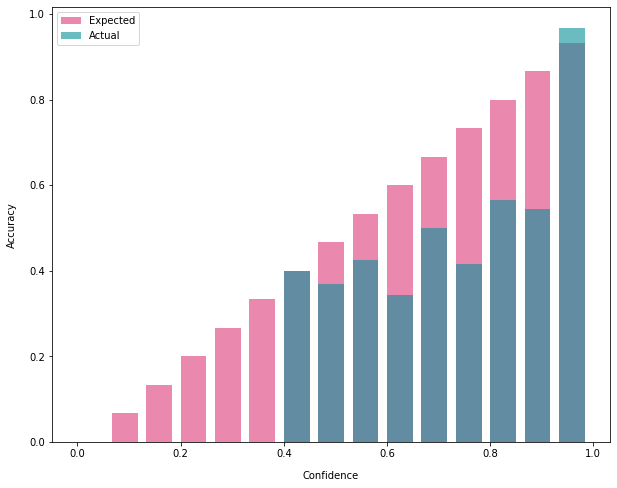

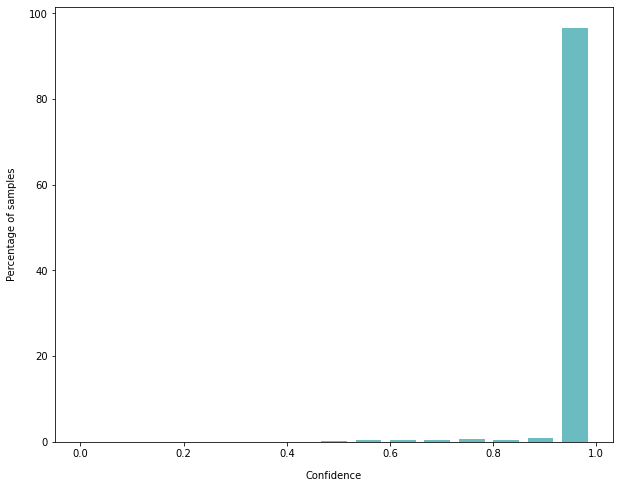

In [12]:
# Evaluating the model at T = 1
# Getting the number of bins
num_bins = 15

net = model(num_classes=num_classes, temp=1.0)
net.cuda()
cudnn.benchmark = True
ckpt = torch.load("checkpoints/Search_Retrain11050540_CEFormat_cifar10_resnet50_num_states=16-2/retrain_latest.pt", map_location='cpu')
net.load_state_dict(ckpt['model'])

conf_matrix, accuracy, labels, predictions, confidences = test_classification_net_focal(net, test_loader, 0)
ece = expected_calibration_error(confidences, predictions, labels, num_bins=num_bins)
mce = maximum_calibration_error(confidences, predictions, labels, num_bins=num_bins)

# Printing the required evaluation metrics
print (conf_matrix)
print ('Test error: ' + str((1 - accuracy)))
print ('ECE: ' + str(ece))
print ('MCE: ' + str(mce))

# Plotting the reliability plot
reliability_plot(confidences, predictions, labels, num_bins=num_bins, save="exp_figs/LFS-MC_pre_T_reliability_plot.pdf")
bin_strength_plot(confidences, predictions, labels, num_bins=num_bins, save="exp_figs/LFS-MC_pre_T_bin_strength_plot.pdf")

[[958   3  10   4   1   1   3   1  13   6]
 [  2 972   0   0   1   0   0   0   1  24]
 [  9   0 926  16  18   9  15   4   2   1]
 [  5   1  12 901   9  43  13   7   5   4]
 [  1   0   7  11 968   6   5   2   0   0]
 [  5   0   5  63  14 900   6   6   0   1]
 [  5   0   4   7   3   3 977   1   0   0]
 [  6   0   2   7   6  10   0 969   0   0]
 [ 19   4   2   0   0   1   0   0 968   6]
 [  2  12   1   3   0   0   1   0   3 978]]
Test error: 0.04830000000000001
ECE: 0.003940820814669068
MCE: 0.09937475095776949


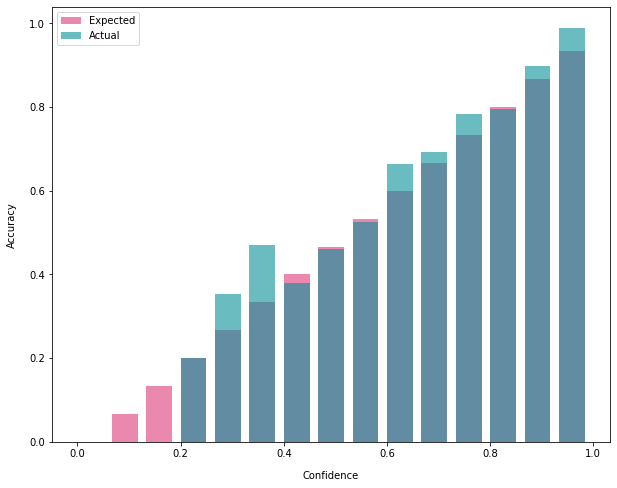

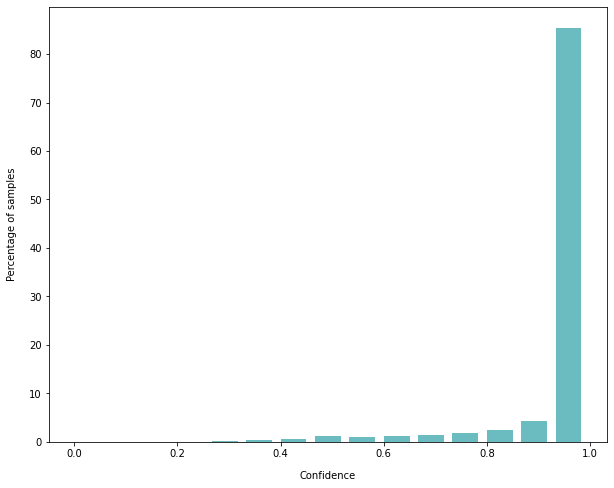

In [13]:
# Evaluating the model at T = T_opt
# Getting the number of bins
t_opt = 3.3

net = model(num_classes=num_classes, temp=t_opt)
net.cuda()
cudnn.benchmark = True
ckpt = torch.load("checkpoints/Search_Retrain11050540_CEFormat_cifar10_resnet50_num_states=16-2/retrain_latest.pt", map_location='cpu')
net.load_state_dict(ckpt['model'])

conf_matrix, accuracy, labels, predictions, confidences, max_logits = test_classification_net_focal(net, test_loader, 0, return_max_logits=True)
ece = expected_calibration_error(confidences, predictions, labels, num_bins=num_bins)
mce = maximum_calibration_error(confidences, predictions, labels, num_bins=num_bins)

print (conf_matrix)
print ('Test error: ' + str((1 - accuracy)))
print ('ECE: ' + str(ece))
print ('MCE: ' + str(mce))

# Plotting the reliability plot
reliability_plot(confidences, predictions, labels, num_bins=num_bins, save="exp_figs/LFS-MC_post_T_reliability_plot.pdf")
bin_strength_plot(confidences, predictions, labels, num_bins=num_bins, save="exp_figs/LFS-MC_post_T_bin_strength_plot.pdf")

# FL53

[[950   1  12  10   0   0   3   1  13  10]
 [  0 976   0   1   0   0   0   0   2  21]
 [  8   0 930  17  18   8  10   5   4   0]
 [  5   2   7 900  11  54   9   6   5   1]
 [  1   0   8  17 958   2   4   8   2   0]
 [  2   0   6  66  13 901   1  10   0   1]
 [  3   0   5  11   3   3 971   2   1   1]
 [  4   1   2   5  13   4   0 971   0   0]
 [ 13   4   2   3   0   1   0   0 971   6]
 [  3  15   0   2   0   0   0   0   7 973]]
Test error: 0.049900000000000055
ECE: 0.015614477089047427
MCE: 0.14781746183122907


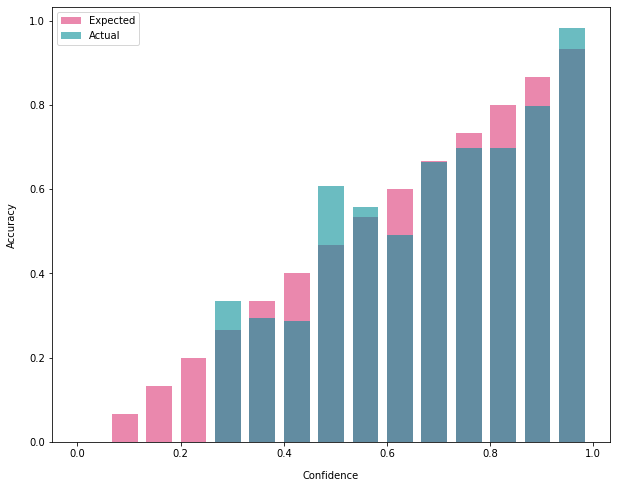

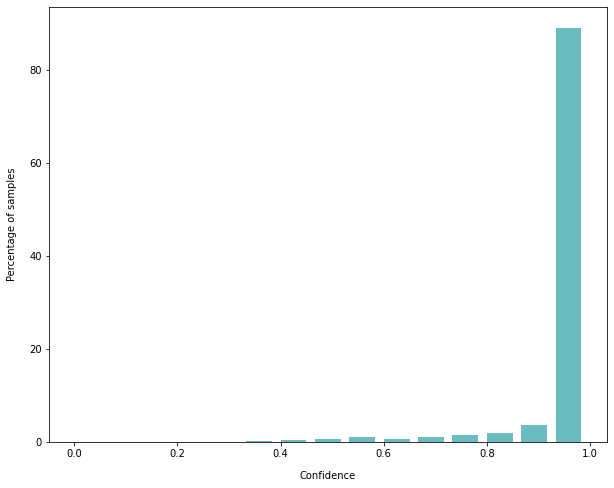

In [14]:
# Evaluating the model at T = 1
# Getting the number of bins
num_bins = 15

net = model(num_classes=num_classes, temp=1.0)
net.cuda()
net = torch.nn.DataParallel(net, device_ids=range(torch.cuda.device_count()))
cudnn.benchmark = True
net.load_state_dict(torch.load("checkpoints/focal_calibration/resnet50_focal_loss_adaptive_53_350.model", map_location='cpu'))

conf_matrix, accuracy, labels, predictions, confidences = test_classification_net_focal(net, test_loader, 0)
ece = expected_calibration_error(confidences, predictions, labels, num_bins=num_bins)
mce = maximum_calibration_error(confidences, predictions, labels, num_bins=num_bins)

# Printing the required evaluation metrics
print (conf_matrix)
print ('Test error: ' + str((1 - accuracy)))
print ('ECE: ' + str(ece))
print ('MCE: ' + str(mce))

# Plotting the reliability plot
reliability_plot(confidences, predictions, labels, num_bins=num_bins, save="exp_figs/FL53_pre_T_reliability_plot.pdf")
bin_strength_plot(confidences, predictions, labels, num_bins=num_bins, save="exp_figs/FL53_pre_T_bin_strength_plot.pdf")

[[950   1  12  10   0   0   3   1  13  10]
 [  0 976   0   1   0   0   0   0   2  21]
 [  8   0 930  17  18   8  10   5   4   0]
 [  5   2   7 900  11  54   9   6   5   1]
 [  1   0   8  17 958   2   4   8   2   0]
 [  2   0   6  66  13 901   1  10   0   1]
 [  3   0   5  11   3   3 971   2   1   1]
 [  4   1   2   5  13   4   0 971   0   0]
 [ 13   4   2   3   0   1   0   0 971   6]
 [  3  15   0   2   0   0   0   0   7 973]]
Test error: 0.049900000000000055
ECE: 0.009333719769120154
MCE: 0.2636646032333374


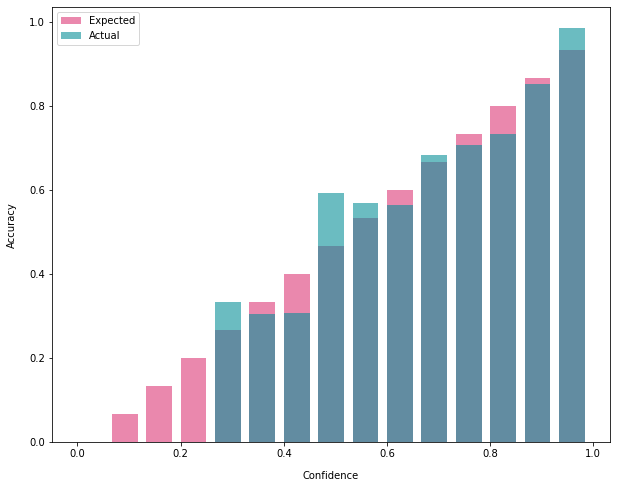

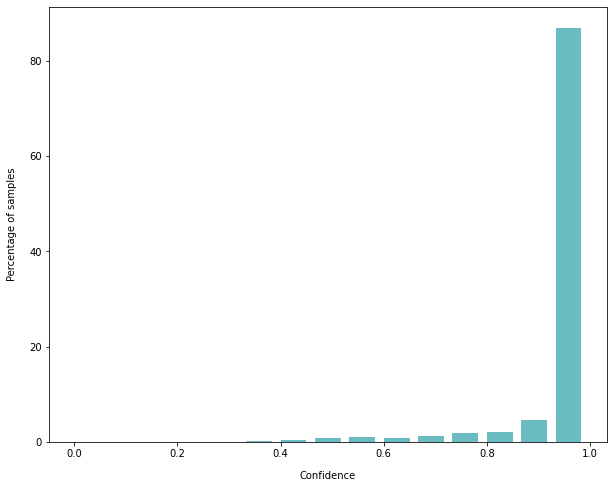

In [15]:
# Evaluating the model at T = T_opt
# Getting the number of bins
t_opt = 1.1

net = model(num_classes=num_classes, temp=t_opt)
net.cuda()
net = torch.nn.DataParallel(net, device_ids=range(torch.cuda.device_count()))
cudnn.benchmark = True
net.load_state_dict(torch.load("checkpoints/focal_calibration/resnet50_focal_loss_adaptive_53_350.model", map_location='cpu'))

conf_matrix, accuracy, labels, predictions, confidences = test_classification_net_focal(net, test_loader, device)
ece = expected_calibration_error(confidences, predictions, labels, num_bins=num_bins)
mce = maximum_calibration_error(confidences, predictions, labels, num_bins=num_bins)

print (conf_matrix)
print ('Test error: ' + str((1 - accuracy)))
print ('ECE: ' + str(ece))
print ('MCE: ' + str(mce))

# Plotting the reliability plot
reliability_plot(confidences, predictions, labels, num_bins=num_bins, save="exp_figs/FL53_post_T_reliability_plot.pdf")
bin_strength_plot(confidences, predictions, labels, num_bins=num_bins, save="exp_figs/FL53_post_T_bin_strength_plot.pdf")

# CE

[[964   2   9   4   3   0   0   0  12   6]
 [  0 980   0   0   0   0   0   0   1  19]
 [  7   1 935  12  14  16  10   1   3   1]
 [  8   1  13 885  15  60   8   3   4   3]
 [  2   0   6  13 965   7   2   5   0   0]
 [  2   1   5  51  12 918   2   9   0   0]
 [  4   1   8   9   8   4 963   0   0   3]
 [  6   0   5   6  13  12   0 956   2   0]
 [ 16   3   3   1   1   0   0   0 971   5]
 [  4  20   0   2   0   0   0   0   6 968]]
Test error: 0.04949999999999999
ECE: 0.04353731756210328
MCE: 0.38374292850494385


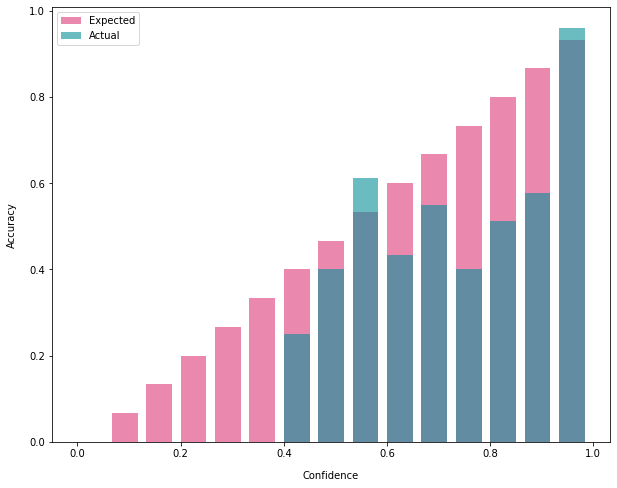

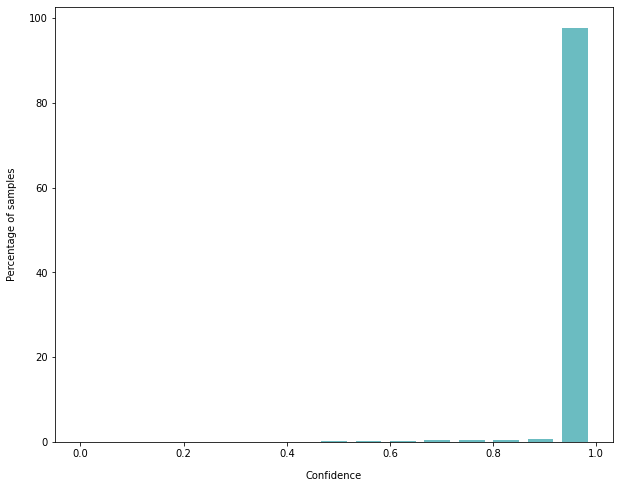

In [16]:
# Evaluating the model at T = 1
# Getting the number of bins
num_bins = 15

net = model(num_classes=num_classes, temp=1.0)
net.cuda()
net = torch.nn.DataParallel(net, device_ids=range(torch.cuda.device_count()))
cudnn.benchmark = True
net.load_state_dict(torch.load("checkpoints/focal_calibration/resnet50_cross_entropy_350.model", map_location='cpu'))

conf_matrix, accuracy, labels, predictions, confidences = test_classification_net_focal(net, test_loader, 0)
ece = expected_calibration_error(confidences, predictions, labels, num_bins=num_bins)
mce = maximum_calibration_error(confidences, predictions, labels, num_bins=num_bins)

# Printing the required evaluation metrics
print (conf_matrix)
print ('Test error: ' + str((1 - accuracy)))
print ('ECE: ' + str(ece))
print ('MCE: ' + str(mce))

# Plotting the reliability plot
reliability_plot(confidences, predictions, labels, num_bins=num_bins, save="exp_figs/CE_pre_T_reliability_plot.pdf")
bin_strength_plot(confidences, predictions, labels, num_bins=num_bins, save="exp_figs/CE_pre_T_bin_strength_plot.pdf")

[[964   2   9   4   3   0   0   0  12   6]
 [  0 980   0   0   0   0   0   0   1  19]
 [  7   1 935  12  14  16  10   1   3   1]
 [  8   1  13 885  15  60   8   3   4   3]
 [  2   0   6  13 965   7   2   5   0   0]
 [  2   1   5  51  12 918   2   9   0   0]
 [  4   1   8   9   8   4 963   0   0   3]
 [  6   0   5   6  13  12   0 956   2   0]
 [ 16   3   3   1   1   0   0   0 971   5]
 [  4  20   0   2   0   0   0   0   6 968]]
Test error: 0.04949999999999999
ECE: 0.013435463973879819
MCE: 0.2059816776143477


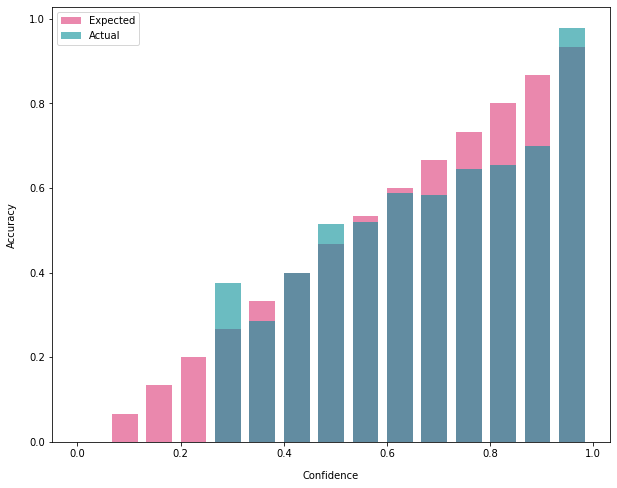

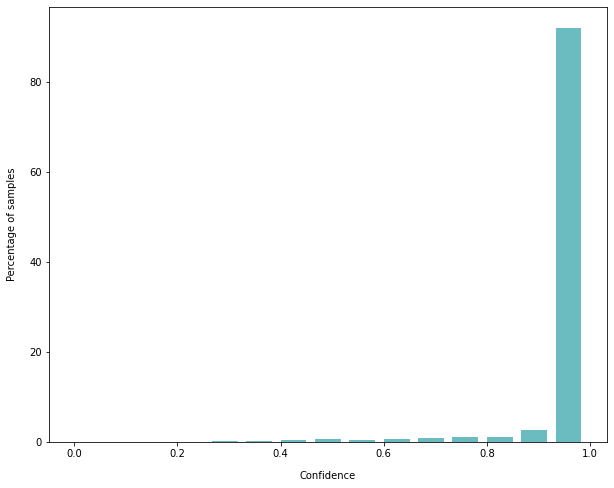

In [17]:
# Evaluating the model at T = T_opt
# Getting the number of bins
t_opt = 2.5

net = model(num_classes=num_classes, temp=t_opt)
net.cuda()
net = torch.nn.DataParallel(net, device_ids=range(torch.cuda.device_count()))
cudnn.benchmark = True
net.load_state_dict(torch.load("checkpoints/focal_calibration/resnet50_cross_entropy_350.model", map_location='cpu'))

conf_matrix, accuracy, labels, predictions, confidences = test_classification_net_focal(net, test_loader, device)
ece = expected_calibration_error(confidences, predictions, labels, num_bins=num_bins)
mce = maximum_calibration_error(confidences, predictions, labels, num_bins=num_bins)

print (conf_matrix)
print ('Test error: ' + str((1 - accuracy)))
print ('ECE: ' + str(ece))
print ('MCE: ' + str(mce))

# Plotting the reliability plot
reliability_plot(confidences, predictions, labels, num_bins=num_bins, save="exp_figs/CE_post_T_reliability_plot.pdf")
bin_strength_plot(confidences, predictions, labels, num_bins=num_bins, save="exp_figs/CE_post_T_bin_strength_plot.pdf")

# MMCE

[[962   1  12   3   2   0   1   0  17   2]
 [  4 975   0   0   0   0   0   0   2  19]
 [ 11   0 917  18  12  20  11   7   4   0]
 [  4   1   7 900  11  57   7   6   5   2]
 [  1   0   7  11 963   7   4   7   0   0]
 [  2   1   4  53   9 922   2   6   0   1]
 [  4   0   6  17   1   2 968   0   0   2]
 [  4   0   0   9  11  10   0 964   1   1]
 [ 22   5   2   2   1   0   0   0 964   4]
 [  6  16   1   3   1   0   0   0   7 966]]
Test error: 0.049900000000000055
ECE: 0.045630604413151726
MCE: 0.6020351052284241


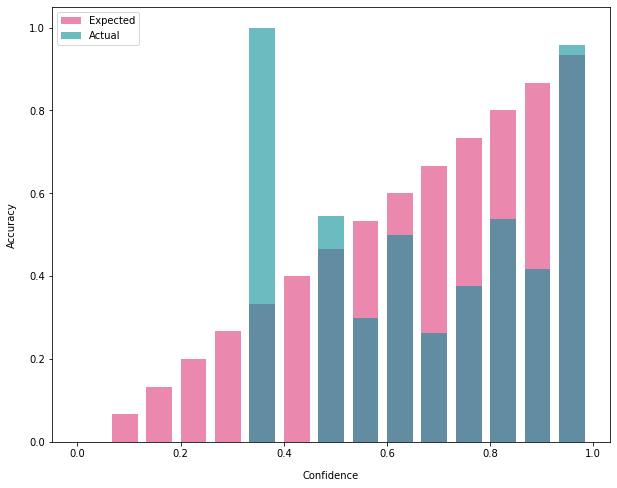

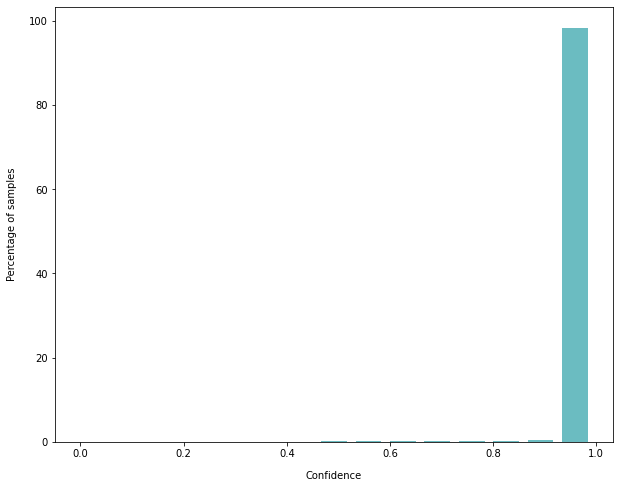

In [18]:

# Evaluating the model at T = 1
# Getting the number of bins
num_bins = 15

net = model(num_classes=num_classes, temp=1.0)
net.cuda()
net = torch.nn.DataParallel(net, device_ids=range(torch.cuda.device_count()))
cudnn.benchmark = True
net.load_state_dict(torch.load("checkpoints/focal_calibration/resnet50_mmce_weighted_lamda_2.0_350.model", map_location='cpu'))

conf_matrix, accuracy, labels, predictions, confidences = test_classification_net_focal(net, test_loader, 0)
ece = expected_calibration_error(confidences, predictions, labels, num_bins=num_bins)
mce = maximum_calibration_error(confidences, predictions, labels, num_bins=num_bins)

# Printing the required evaluation metrics
print (conf_matrix)
print ('Test error: ' + str((1 - accuracy)))
print ('ECE: ' + str(ece))
print ('MCE: ' + str(mce))

# Plotting the reliability plot
reliability_plot(confidences, predictions, labels, num_bins=num_bins, save="exp_figs/MMCE_pre_T_reliability_plot.pdf")
bin_strength_plot(confidences, predictions, labels, num_bins=num_bins, save="exp_figs/MMCE_pre_T_bin_strength_plot.pdf")

[[964   2   9   4   3   0   0   0  12   6]
 [  0 980   0   0   0   0   0   0   1  19]
 [  7   1 935  12  14  16  10   1   3   1]
 [  8   1  13 885  15  60   8   3   4   3]
 [  2   0   6  13 965   7   2   5   0   0]
 [  2   1   5  51  12 918   2   9   0   0]
 [  4   1   8   9   8   4 963   0   0   3]
 [  6   0   5   6  13  12   0 956   2   0]
 [ 16   3   3   1   1   0   0   0 971   5]
 [  4  20   0   2   0   0   0   0   6 968]]
Test error: 0.04949999999999999
ECE: 0.013019791999459289
MCE: 0.17042578732697322


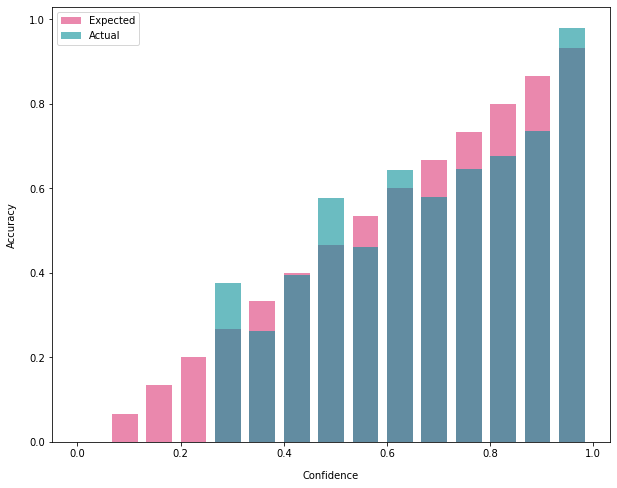

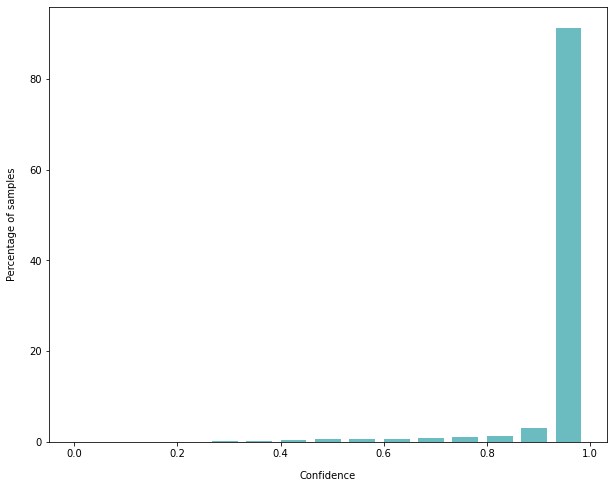

In [19]:
# Evaluating the model at T = T_opt
# Getting the number of bins
t_opt = 2.6

net = model(num_classes=num_classes, temp=t_opt)
net.cuda()
net = torch.nn.DataParallel(net, device_ids=range(torch.cuda.device_count()))
cudnn.benchmark = True
net.load_state_dict(torch.load("checkpoints/focal_calibration/resnet50_cross_entropy_350.model", map_location='cpu'))

conf_matrix, accuracy, labels, predictions, confidences = test_classification_net_focal(net, test_loader, device)
ece = expected_calibration_error(confidences, predictions, labels, num_bins=num_bins)
mce = maximum_calibration_error(confidences, predictions, labels, num_bins=num_bins)

print (conf_matrix)
print ('Test error: ' + str((1 - accuracy)))
print ('ECE: ' + str(ece))
print ('MCE: ' + str(mce))

# Plotting the reliability plot
reliability_plot(confidences, predictions, labels, num_bins=num_bins, save="exp_figs/MMCE_post_T_reliability_plot.pdf")
bin_strength_plot(confidences, predictions, labels, num_bins=num_bins, save="exp_figs/MMCE_post_T_bin_strength_plot.pdf")

# Brier Loss

[[963   0  12   5   1   0   0   0  13   6]
 [  3 975   0   0   0   0   0   0   2  20]
 [ 15   0 920  15  17  13  16   1   2   1]
 [  8   1  12 883  18  55  11   3   5   4]
 [  2   0   2  18 960   8   6   2   2   0]
 [  3   1   8  58  11 913   2   4   0   0]
 [  5   0   3  13   4   1 972   1   0   1]
 [  3   0   6   4   9  10   0 966   1   1]
 [ 13   5   1   1   1   0   0   0 975   4]
 [  5  16   0   2   0   0   0   0   5 972]]
Test error: 0.05010000000000003
ECE: 0.01807509601712229
MCE: 0.31589773297309875


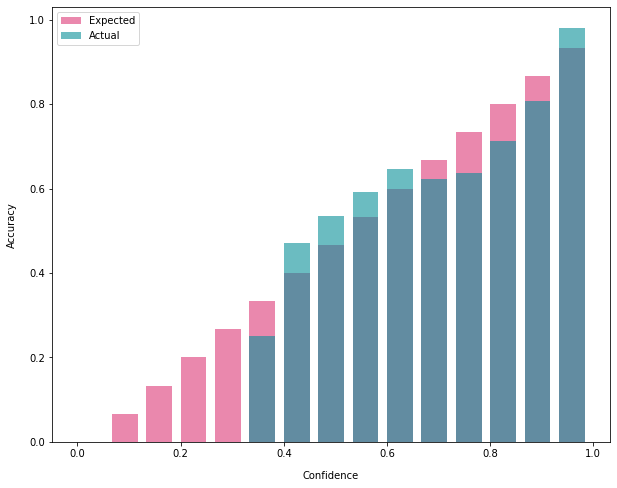

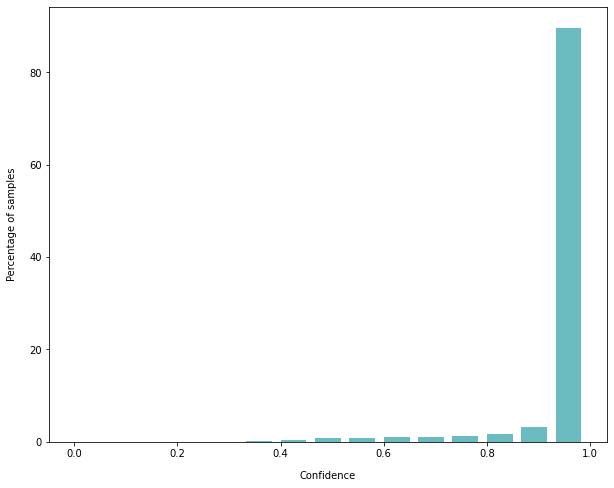

In [20]:

# Evaluating the model at T = 1
# Getting the number of bins
num_bins = 15

net = model(num_classes=num_classes, temp=1.0)
net.cuda()
net = torch.nn.DataParallel(net, device_ids=range(torch.cuda.device_count()))
cudnn.benchmark = True
net.load_state_dict(torch.load("checkpoints/focal_calibration/resnet50_brier_score_350.model", map_location='cpu'))

conf_matrix, accuracy, labels, predictions, confidences = test_classification_net_focal(net, test_loader, 0)
ece = expected_calibration_error(confidences, predictions, labels, num_bins=num_bins)
mce = maximum_calibration_error(confidences, predictions, labels, num_bins=num_bins)

# Printing the required evaluation metrics
print (conf_matrix)
print ('Test error: ' + str((1 - accuracy)))
print ('ECE: ' + str(ece))
print ('MCE: ' + str(mce))

# Plotting the reliability plot
reliability_plot(confidences, predictions, labels, num_bins=num_bins, save="exp_figs/Brier_Loss_pre_T_reliability_plot.pdf")
bin_strength_plot(confidences, predictions, labels, num_bins=num_bins, save="exp_figs/Brier_Loss_pre_T_bin_strength_plot.pdf")


[[963   0  12   5   1   0   0   0  13   6]
 [  3 975   0   0   0   0   0   0   2  20]
 [ 15   0 920  15  17  13  16   1   2   1]
 [  8   1  12 883  18  55  11   3   5   4]
 [  2   0   2  18 961   8   5   2   2   0]
 [  3   1   8  58  11 913   2   4   0   0]
 [  5   0   3  13   4   1 972   1   0   1]
 [  3   0   6   4   9  10   0 966   1   1]
 [ 13   5   1   1   1   0   0   0 975   4]
 [  5  16   0   2   0   0   0   0   5 972]]
Test error: 0.050000000000000044
ECE: 0.010792116157710571
MCE: 0.22452492639422417


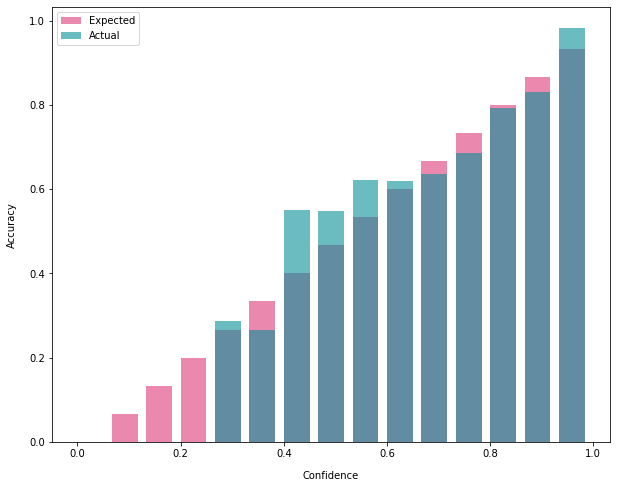

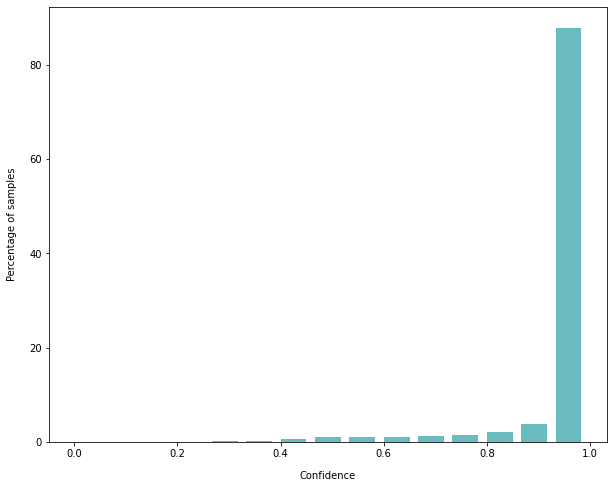

In [21]:
# Evaluating the model at T = T_opt
# Getting the number of bins
t_opt = 1.1

net = model(num_classes=num_classes, temp=t_opt)
net.cuda()
net = torch.nn.DataParallel(net, device_ids=range(torch.cuda.device_count()))
cudnn.benchmark = True
net.load_state_dict(torch.load("checkpoints/focal_calibration/resnet50_brier_score_350.model", map_location='cpu'))

conf_matrix, accuracy, labels, predictions, confidences = test_classification_net_focal(net, test_loader, device)
ece = expected_calibration_error(confidences, predictions, labels, num_bins=num_bins)
mce = maximum_calibration_error(confidences, predictions, labels, num_bins=num_bins)

print (conf_matrix)
print ('Test error: ' + str((1 - accuracy)))
print ('ECE: ' + str(ece))
print ('MCE: ' + str(mce))

# Plotting the reliability plot
reliability_plot(confidences, predictions, labels, num_bins=num_bins, save="exp_figs/Brier_Loss_post_T_reliability_plot.pdf")
bin_strength_plot(confidences, predictions, labels, num_bins=num_bins, save="exp_figs/Brier_Loss_post_T_bin_strength_plot.pdf")

# LS-0.5

[[962   1  11   7   0   0   1   1  15   2]
 [  2 981   0   0   0   0   0   0   2  15]
 [  9   0 918  18  11  16  19   8   1   0]
 [  7   0  13 872   9  74  11   6   2   6]
 [  2   0   9  15 957   8   2   7   0   0]
 [  0   1   5  57  10 914   2  11   0   0]
 [  5   0   5  11   3   4 970   0   0   2]
 [  4   0   2   2  12   9   0 971   0   0]
 [ 29   4   2   1   1   0   0   0 959   4]
 [  5  20   0   2   0   0   0   0   6 967]]
Test error: 0.05289999999999995
ECE: 0.02967786841392515
MCE: 0.37185923166053236


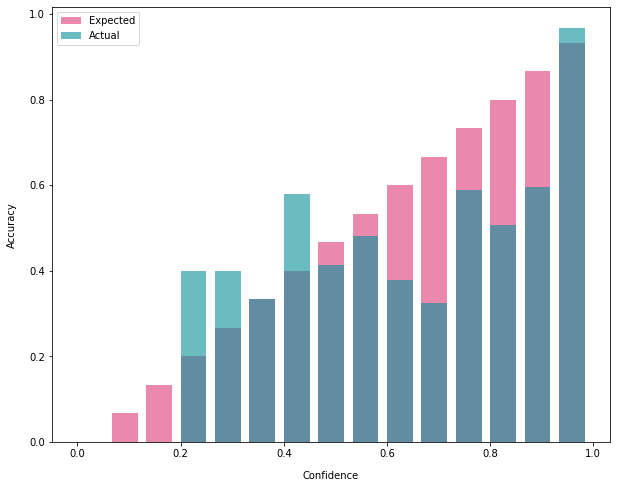

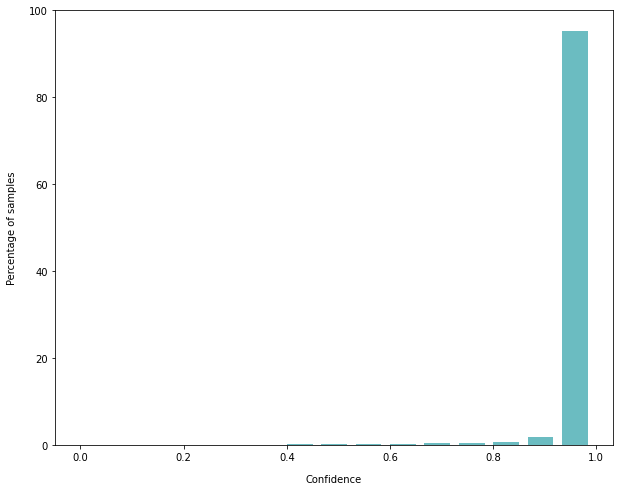

In [22]:

# Evaluating the model at T = 1
# Getting the number of bins
num_bins = 15

net = model(num_classes=num_classes, temp=1.0)
net.cuda()
net = torch.nn.DataParallel(net, device_ids=range(torch.cuda.device_count()))
cudnn.benchmark = True
net.load_state_dict(torch.load("checkpoints/focal_calibration/resnet50_cross_entropy_smoothed_smoothing_0.05_350.model", map_location='cpu'))

conf_matrix, accuracy, labels, predictions, confidences = test_classification_net_focal(net, test_loader, 0)
ece = expected_calibration_error(confidences, predictions, labels, num_bins=num_bins)
mce = maximum_calibration_error(confidences, predictions, labels, num_bins=num_bins)

# Printing the required evaluation metrics
print (conf_matrix)
print ('Test error: ' + str((1 - accuracy)))
print ('ECE: ' + str(ece))
print ('MCE: ' + str(mce))

# Plotting the reliability plot
reliability_plot(confidences, predictions, labels, num_bins=num_bins, save="exp_figs/LS-0.5_pre_T_reliability_plot.pdf")
bin_strength_plot(confidences, predictions, labels, num_bins=num_bins, save="exp_figs/LS-0.5_pre_T_bin_strength_plot.pdf")


[[962   1  11   7   0   0   1   1  15   2]
 [  2 981   0   0   0   0   0   0   2  15]
 [  9   0 918  18  11  16  19   8   1   0]
 [  7   0  13 872   9  74  11   6   2   6]
 [  2   0   9  15 957   8   2   7   0   0]
 [  0   1   5  57  10 914   2  11   0   0]
 [  5   0   5  11   3   4 970   0   0   2]
 [  4   0   2   2  12   9   0 971   0   0]
 [ 29   4   2   1   1   0   0   0 959   4]
 [  5  20   0   2   0   0   0   0   6 967]]
Test error: 0.05289999999999995
ECE: 0.016777463637292468
MCE: 0.3556637533686377


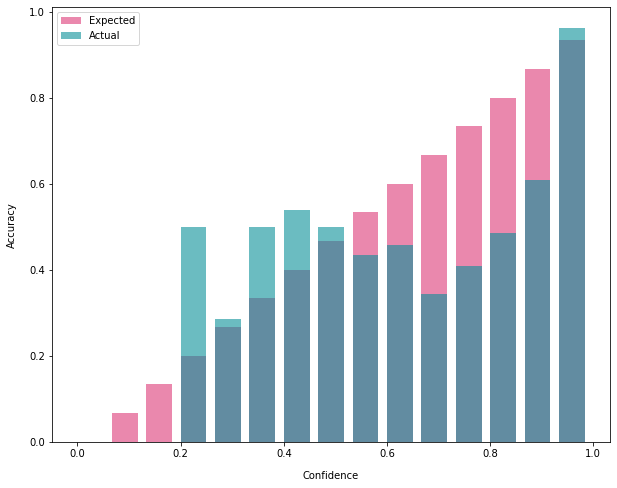

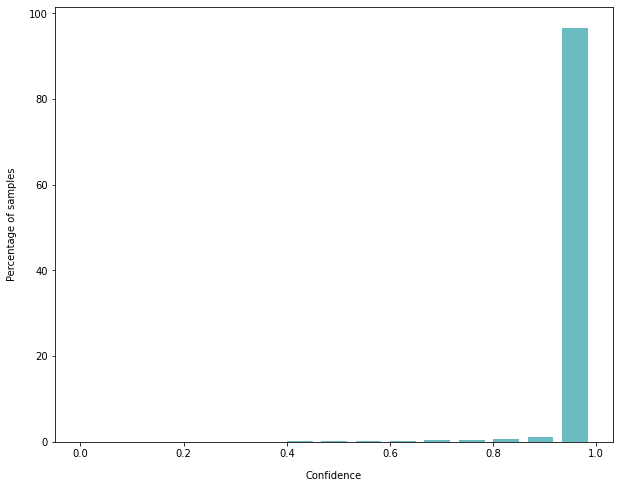

In [23]:
# Evaluating the model at T = T_opt
# Getting the number of bins
t_opt = 0.9

net = model(num_classes=num_classes, temp=t_opt)
net.cuda()
net = torch.nn.DataParallel(net, device_ids=range(torch.cuda.device_count()))
cudnn.benchmark = True
net.load_state_dict(torch.load("checkpoints/focal_calibration/resnet50_cross_entropy_smoothed_smoothing_0.05_350.model", map_location='cpu'))

conf_matrix, accuracy, labels, predictions, confidences = test_classification_net_focal(net, test_loader, device)
ece = expected_calibration_error(confidences, predictions, labels, num_bins=num_bins)
mce = maximum_calibration_error(confidences, predictions, labels, num_bins=num_bins)

print (conf_matrix)
print ('Test error: ' + str((1 - accuracy)))
print ('ECE: ' + str(ece))
print ('MCE: ' + str(mce))

# Plotting the reliability plot
reliability_plot(confidences, predictions, labels, num_bins=num_bins, save="exp_figs/LS-0.5_post_T_reliability_plot.pdf")
bin_strength_plot(confidences, predictions, labels, num_bins=num_bins, save="exp_figs/LS-0.5_post_T_bin_strength_plot.pdf")

# FL-3

[[955   0   9   8   0   0   0   0  18  10]
 [  1 974   0   0   0   0   0   0   1  24]
 [  9   0 933  11  17  14  10   4   2   0]
 [  6   1  16 879  12  66   8   6   3   3]
 [  1   0   5  19 960   6   4   4   1   0]
 [  1   0  12  56   9 913   3   5   1   0]
 [  3   0  11  11   4   2 967   1   1   0]
 [  5   0   3   4  12  12   1 961   2   0]
 [ 15   7   4   1   1   0   0   0 966   6]
 [  6  17   0   3   0   0   0   0   7 967]]
Test error: 0.05249999999999999
ECE: 0.014999433982372353
MCE: 0.22474366165044013


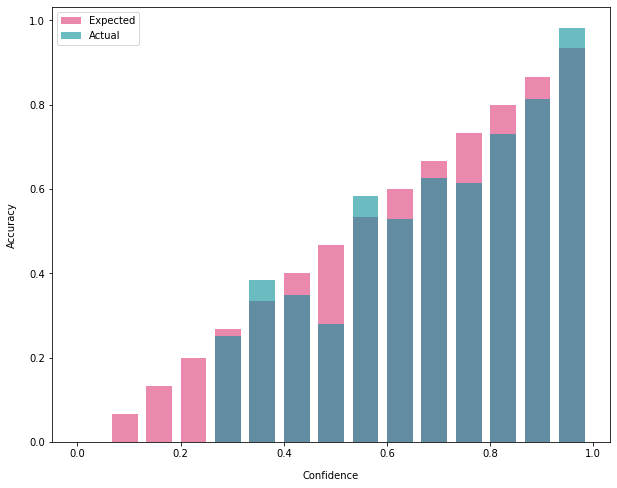

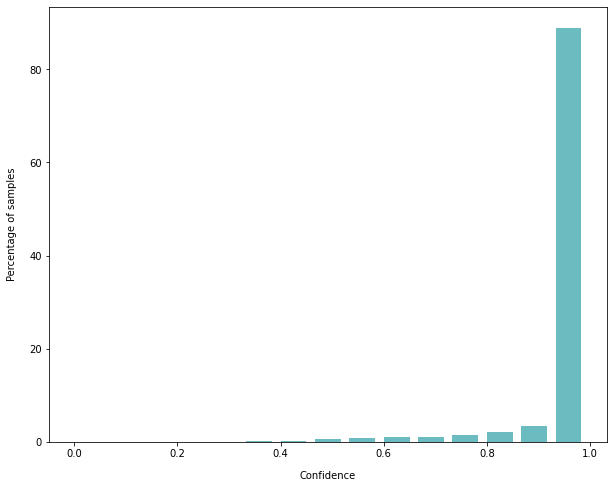

In [24]:

# Evaluating the model at T = 1
# Getting the number of bins
num_bins = 15

net = model(num_classes=num_classes, temp=1.0)
net.cuda()
net = torch.nn.DataParallel(net, device_ids=range(torch.cuda.device_count()))
cudnn.benchmark = True
net.load_state_dict(torch.load("checkpoints/focal_calibration/resnet50_focal_loss_gamma_3.0_350.model", map_location='cpu'))

conf_matrix, accuracy, labels, predictions, confidences = test_classification_net_focal(net, test_loader, 0)
ece = expected_calibration_error(confidences, predictions, labels, num_bins=num_bins)
mce = maximum_calibration_error(confidences, predictions, labels, num_bins=num_bins)

# Printing the required evaluation metrics
print (conf_matrix)
print ('Test error: ' + str((1 - accuracy)))
print ('ECE: ' + str(ece))
print ('MCE: ' + str(mce))

# Plotting the reliability plot
reliability_plot(confidences, predictions, labels, num_bins=num_bins, save="exp_figs/FL3_pre_T_reliability_plot.pdf")
bin_strength_plot(confidences, predictions, labels, num_bins=num_bins, save="exp_figs/FL3_pre_T_bin_strength_plot.pdf")

[[955   0   9   8   0   0   0   0  18  10]
 [  1 974   0   0   0   0   0   0   1  24]
 [  9   0 933  11  17  14  10   4   2   0]
 [  6   1  16 879  12  66   8   6   3   3]
 [  1   0   5  19 960   6   4   4   1   0]
 [  1   0  12  56   9 913   3   5   1   0]
 [  3   0  11  11   4   2 967   1   1   0]
 [  5   0   3   4  12  12   1 961   2   0]
 [ 15   7   4   1   1   0   0   0 966   6]
 [  6  17   0   3   0   0   0   0   7 967]]
Test error: 0.05249999999999999
ECE: 0.014440419918298763
MCE: 0.15749259293079376


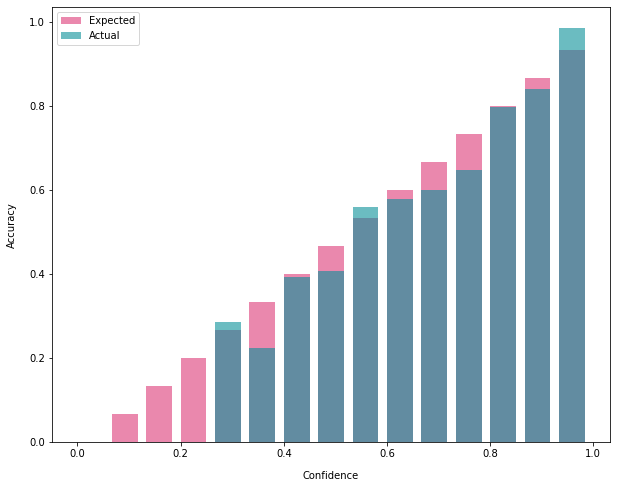

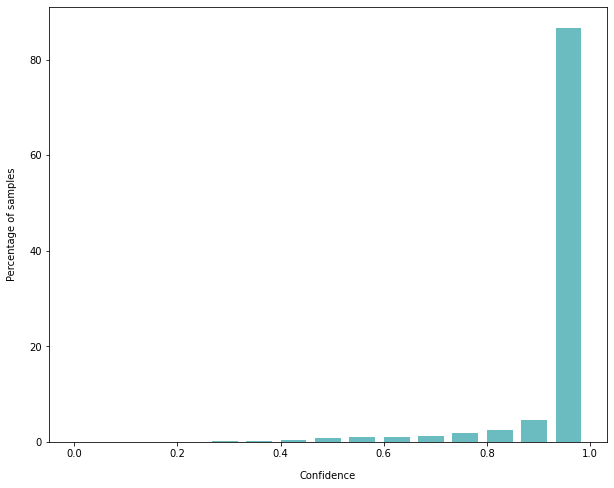

In [25]:
# Evaluating the model at T = T_opt
# Getting the number of bins
t_opt = 1.1

net = model(num_classes=num_classes, temp=t_opt)
net.cuda()
net = torch.nn.DataParallel(net, device_ids=range(torch.cuda.device_count()))
cudnn.benchmark = True
net.load_state_dict(torch.load("checkpoints/focal_calibration/resnet50_focal_loss_gamma_3.0_350.model", map_location='cpu'))

conf_matrix, accuracy, labels, predictions, confidences = test_classification_net_focal(net, test_loader, device)
ece = expected_calibration_error(confidences, predictions, labels, num_bins=num_bins)
mce = maximum_calibration_error(confidences, predictions, labels, num_bins=num_bins)

print (conf_matrix)
print ('Test error: ' + str((1 - accuracy)))
print ('ECE: ' + str(ece))
print ('MCE: ' + str(mce))

# Plotting the reliability plot
reliability_plot(confidences, predictions, labels, num_bins=num_bins, save="exp_figs/FL3_post_T_reliability_plot.pdf")
bin_strength_plot(confidences, predictions, labels, num_bins=num_bins, save="exp_figs/FL3_post_T_bin_strength_plot.pdf")